In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from calendar import isleap
from scipy.interpolate import griddata
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import nctoolkit as nct
from scipy.interpolate import Rbf
import netCDF4 as nc
import xarray as xr
import datetime

Please install CDO version 1.9.7 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo


### Function to find lines to skip in weather files

In [2]:

def find_line(path, target):
    with open(path) as fh:
        count = 1
        for line in fh:
#             print(line.strip()[0:5])
            if line.strip()[0:5] == target:
                return count
            count += 1
    return 0

### Using 47 stations in Nigeria


In [3]:
coords = pd.read_csv("coords1.csv")
coords = coords.sort_values("stn")
stn = coords["stn"]
long = coords["lon"]
lati = coords["lat"]
# coord

In [4]:
all_stn_wth_files_tmax = pd.DataFrame(columns=["DATE"])

for station in stn:
#     print(station)
    all_wth_files_tmax = []
    # read each station data from weather files
    weather_files = glob.glob("Weather/Weather/" + station + "*.WTH")
    for file in weather_files:
#         print(weather_files)
        to_skip = find_line(path=file, target="@DATE")
        wth_file = pd.read_fwf(file, skiprows = to_skip, 
                               usecols = [0,2,3,4],
                               names = ["DATE", "TMAX", "TMIN", "RAIN"],
                               dtype={"DATE":str})
        wth_file.DATE[0][0:2]
        if float(wth_file.DATE[0][0:2]) < 50:
            year = "20" + wth_file.DATE[0][0:2]
        else:
            year = "19" + wth_file.DATE[0][0:2]
#             print(year)
        wth_file["YEAR"] = year
        wth_file["DOY"] = list(range(1,len(wth_file)+1))
        
        if isleap(float(year)):
            days_in_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        else:
            days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
            
#         print(file, year, to_skip, wth_file.DATE[0][0:2], len(wth_file.columns), days_in_month)
            
        wth_file["DAYS"] = np.concatenate([list(range(1, i+1)) for i in days_in_month])
        wth_file["MONTHS"] = np.concatenate([[j]*i for i, j in zip(days_in_month, list(range(1,13)))])
        wth_file["DATE"] = wth_file["DAYS"].astype(str) + "/" + wth_file["MONTHS"].astype(str) + "/" + wth_file["YEAR"]
        wth_file_tmax = wth_file[["DATE","TMAX"]]
        wth_file_tmax.columns = ["DATE", station]
        all_wth_files_tmax.append(wth_file_tmax)
    all_wth_files_tmax = pd.concat(all_wth_files_tmax, axis = 0)
    
    all_stn_wth_files_tmax = all_stn_wth_files_tmax.merge(all_wth_files_tmax, left_on="DATE", right_on="DATE", how = "outer")




In [5]:
all_stn_wth_files_tmax["DATE"] = pd.to_datetime(all_stn_wth_files_tmax["DATE"])
all_stn_wth_files_tmax = all_stn_wth_files_tmax.sort_values("DATE")

# all_stn_wth_files_tmax.info()

## Interpolation
### Target grid to interpolate to
Here, we choose a resolution of 1 degree

In [6]:
res = 1
lonvals = latvals = np.arange(2,16,res)
lonvals,latvals = np.meshgrid(lonvals,latvals)

In [7]:
## # interpolate
# # newtmax = griddata((tmaxlon,tmaxlat),tmaxvals,
# #                    (lonvals,latvals),method='linear',  rescale = True)

# rbfi = Rbf(lon, lat, tmaxvals)
# newtmax = rbfi(lonvals, latvals)


# # plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# #ax = plt.axes(projection=ccrs.PlateCarree())

# # dat = ax.contourf(lonvals,latvals,newtmax, cmap='coolwarm')
# dat = ax.imshow(newtmax, interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
# ax.plot(lon,lat,'k.')
# ax.set_global()
# ax.coastlines()
# ax.set_extent([2, 14, 2, 14])
# ax.add_feature(cfeature.BORDERS)

# # Define the xticks for longitude
# ax.set_xticks(np.arange(2,15, 2), crs=ccrs.PlateCarree())
# lon_formatter = cticker.LongitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# # Define the yticks for latitude
# ax.set_yticks(np.arange(2, 15,2), crs=ccrs.PlateCarree())
# lat_formatter = cticker.LatitudeFormatter()
# ax.yaxis.set_major_formatter(lat_formatter)

# plt.xlabel('Longitude',fontsize=16)
# plt.ylabel('Latitude',fontsize=16)
# plt.colorbar(dat)
# # plt.savefig('linear_interpolated.jpg')
# #plt.close(fig)




In [8]:
# # interpolate
# # newtmax = griddata((lon,lat), all_stn_wth_files_tmax[11100:11101][stn].squeeze(axis = 0),
# #                    (lonvals,latvals),method='nearest')

# # plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# #ax = plt.axes(projection=ccrs.PlateCarree())

# dat = ax.contourf(lonvals,latvals,newtmax, cmap='coolwarm')
# ax.plot(long,lati,'k.')
# ax.set_global()
# ax.coastlines()
# ax.set_extent([2, 14.9, 2, 14.8])
# ax.add_feature(cfeature.BORDERS)

# # Define the xticks for longitude
# ax.set_xticks(np.arange(2,15, 2), crs=ccrs.PlateCarree())
# lon_formatter = cticker.LongitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# # Define the yticks for latitude
# ax.set_yticks(np.arange(2, 15,2), crs=ccrs.PlateCarree())
# lat_formatter = cticker.LatitudeFormatter()
# ax.yaxis.set_major_formatter(lat_formatter)

# plt.xlabel('Longitude',fontsize=16)
# plt.ylabel('Latitude',fontsize=16)
# plt.colorbar(dat)

# # plt.savefig('linear_interpolated.jpg')
# #plt.close(fig)

### Creating the NetCDF file

In [9]:
filename = "NiMet_Tmax_1971_2021.nc"
ds = nc.Dataset(filename, "w", format = "NETCDF4")

# Add dimensions
lat = ds.createDimension('lat', len(latvals))
lon = ds.createDimension('lon', len(lonvals))
time = ds.createDimension('time', None)

# Create varaiables
lats = ds.createVariable('lat', 'f4', ('lat',))
lons = ds.createVariable('lon', 'f4', ('lon',))
times = ds.createVariable('time', 'f8', ('time',))
Tmax = ds.createVariable('Tmax', 'f4', ('time', 'lat', 'lon'))
Tmax.units = 'degrees celsius'

#Add Attributes
lats.long_name = 'Latitude'
lats.units = 'degrees_north'
lats.standard_name = 'latitude'
lats.axis = 'Y'

lons.long_name = 'Longitude'
lons.units = 'degrees_east'
lons.standard_name = 'longitude'
lons.axis = 'X'

times.long_name = 'time'
calendar = 'gregorian'
times.units = 'days since 1971-01-01'


#Assign longitude and latitude Values
lats[:] = np.arange(2, 16, res)
lons[:] = np.arange(2, 16, res)


#Assign netcdf Tmax Values for all time step in the data

for i in range(len(all_stn_wth_files_tmax)):
    times[i] = i
    Tmax[i, :, :] =  griddata((long, lati), all_stn_wth_files_tmax[i:i+1][stn].squeeze(axis = 0), (lonvals,latvals), method='nearest').reshape(len(lonvals), len(latvals))
    

ds.close()

In [10]:
tmax = xr.open_dataset("NiMet_Tmax_1971_2021.nc")
tmax

<xarray.Dataset>
Dimensions:  (lat: 14, lon: 14, time: 18628)
Coordinates:
  * lat      (lat) float32 2.0 3.0 4.0 5.0 6.0 7.0 ... 11.0 12.0 13.0 14.0 15.0
  * lon      (lon) float32 2.0 3.0 4.0 5.0 6.0 7.0 ... 11.0 12.0 13.0 14.0 15.0
  * time     (time) datetime64[ns] 1971-01-01 1971-01-02 ... 2021-12-31
Data variables:
    Tmax     (time, lat, lon) float32 ...

A quick plot

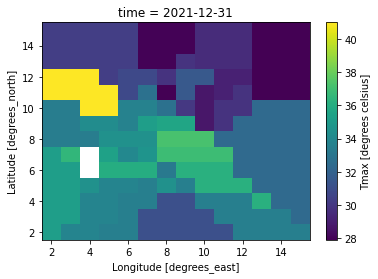

In [11]:

tmax.Tmax.isel(time = -1).plot()
